# Inference RelateAnything with PSG

In [1]:
%load_ext autoreload
%autoreload 2

from segment_anything import build_sam, SamPredictor, SamAutomaticMaskGenerator

/mnt/lustre/jkyang/anaconda3/envs/relate_anything/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
predictor = SamPredictor(build_sam(
    checkpoint="./segment_anything/checkpoints/sam_vit_h_4b8939.pth"))
mask_generator = SamAutomaticMaskGenerator(build_sam(
    checkpoint="./segment_anything/checkpoints/sam_vit_h_4b8939.pth"))

### Some Useful Functions

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def sort_and_deduplicate(sam_masks, iou_threshold=0.8):
    # Sort the sam_masks list based on the area value
    sorted_masks = sorted(sam_masks, key=lambda x: x['area'], reverse=True)

    # Deduplicate masks based on the given iou_threshold
    filtered_masks = []
    for mask in sorted_masks:
        duplicate = False
        for filtered_mask in filtered_masks:
            if iou(mask['segmentation'], filtered_mask['segmentation']) > iou_threshold:
                duplicate = True
                break

        if not duplicate:
            filtered_masks.append(mask)

    return filtered_masks

In [4]:
def show_anns(anns, color_code='auto'):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        if color_code == 'auto':
            for i in range(3):
                img[:,:,i] = color_mask[i]
        elif color_code == 'red':
            for i in range(3):
                img[:,:,0] = 1
                img[:,:,1] = 0
                img[:,:,2] = 0
        else:
            for i in range(3):
                img[:,:,0] = 0
                img[:,:,1] = 0
                img[:,:,2] = 1
    return np.dstack((img, m*0.35))

In [5]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', 
               s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', 
               s=marker_size, edgecolor='white', linewidth=1.25)   

def show_mask(m, color_code='red'):
    img = np.ones((m.shape[0], m.shape[1], 3))
    color_mask = np.random.random((1, 3)).tolist()[0]
    if color_code == 'auto':
        for i in range(3):
            img[:,:,i] = color_mask[i]
    elif color_code == 'red':
        for i in range(3):
            img[:,:,0] = 1
            img[:,:,1] = 0
            img[:,:,2] = 0
    else:
        for i in range(3):
            img[:,:,0] = 0
            img[:,:,1] = 0
            img[:,:,2] = 1

    return np.dstack((img, m*0.35))

### Model Loading

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from ram_train_eval import RamModel,RamPredictor
from mmcv import Config

In [7]:
class Predictor(RamPredictor):
    def __init__(self,config):
        self.config = config
        self.device = torch.device(
            'cuda' if torch.cuda.is_available() else 'cpu')
        self._build_model()

    def _build_model(self):
        self.model = RamModel(**self.config.model).to(self.device)
        if self.config.load_from is not None:
            self.model.load_state_dict(torch.load(self.config.load_from, map_location=self.device))
        self.model.train()

In [189]:
# load model
model_path = "epoch_9.pth"
config = dict(
    model=dict(
        pretrained_model_name_or_path='bert-base-uncased',
        load_pretrained_weights=False,
        num_transformer_layer=2,
        input_feature_size=256,
        output_feature_size=768,
        cls_feature_size=512,
        num_relation_classes=56,
        pred_type='attention',
        loss_type='multi_label_ce',
    ),
    load_from=model_path,
)
config = Config(config)
model = Predictor(config)


Use Multi Label Cross Entropy Loss.


## Demo

In [10]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

image_name = 'psg_data/coco/val2017/000000012748.jpg'
image_name = './images/dog.jpg'

image = cv2.imread(image_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pilimage = Image.open(image_name)
width, height = pilimage.size
full_area = width * height

### Step 1: User click object

In [11]:
predictor.set_image(image)

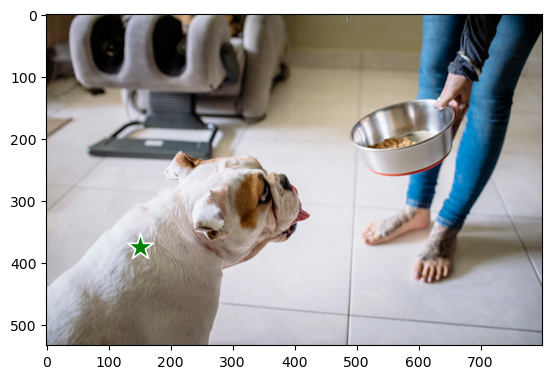

In [18]:
# # dog
# input_point = np.array([[400, 375],[400, 250],[430,600]])
# input_label = np.array([1,1,1])

# dog
input_point = np.array([[150, 375]])
input_label = np.array([1])


# # bowl
# input_point = np.array([[600, 200]])
# input_label = np.array([1])

# human
# input_point = np.array([[700, 50]])
# input_label = np.array([1])

# ground
# input_point = np.array([[500, 400]])
# input_label = np.array([1])

plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.show()

mask1, score1, logit1, feat1 = predictor.predict(point_coords=input_point,
                                                 point_labels=input_label,
                                                 multimask_output=False,)

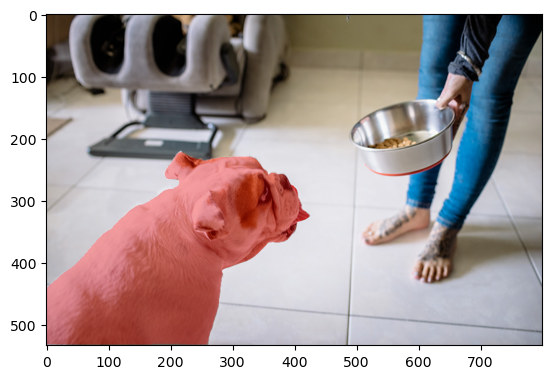

In [21]:
plt.imshow(image)
plt.imshow(show_mask(mask1[0]))
plt.show()

### Step 2: Segment Anything

In [22]:
sam_masks = mask_generator.generate(image)

/mnt/lustre/jkyang/PSG4D/RelateAnything/segment_anything/segment_anything/utils/amg.py:118: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729009598/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  change_indices = diff.nonzero()


In [23]:
# remove very small items, duplicate items, and itself
# filtered_masks = [d for d in sam_masks if iou(d['segmentation'], mask1[0]) < 0.95]
# filtered_masks = [d for d in filtered_masks if d['area'] > 0.03 * full_area]

filtered_masks = sort_and_deduplicate(sam_masks)
print('number of masks left:', len(filtered_masks))

number of masks left: 58


### Step 3: Setup Relations

In [24]:
relation_classes = [
    'over', 'in front of', 'beside', 'on', 'in', 'attached to', 'hanging from', 'on back of', 'falling off', 
    'going down', 'painted on', 'walking on', 'running on', 'crossing', 'standing on', 'lying on', 'sitting on', 
    'flying over', 'jumping over', 'jumping from', 'wearing', 'holding', 'carrying', 'looking at', 'guiding', 
    'kissing', 'eating', 'drinking', 'feeding', 'biting', 'catching', 'picking', 'playing with', 'chasing', 
    'climbing', 'cleaning', 'playing', 'touching', 'pushing', 'pulling', 'opening', 'cooking', 'talking to', 
    'throwing', 'slicing', 'driving', 'riding', 'parked on', 'driving on', 'about to hit', 'kicking', 'swinging', 
    'entering', 'exiting', 'enclosing', 'leaning on']

In [33]:
k = 1

In [187]:
feat = feat1
for fm in filtered_masks:
    feat2 = torch.Tensor(fm['feat']).unsqueeze(0).unsqueeze(0)
    feat = torch.cat((feat, feat2), dim=1)

In [190]:
matrix_output, rel_triplets = model.predict(feat)

In [113]:
subject_output = matrix_output.permute([0,2,3,1])[:,0,1:]
object_output = matrix_output.permute([0,3,2,1])[:,0,1:]

In [120]:
all_output = torch.cat([subject_output, object_output], dim=0)

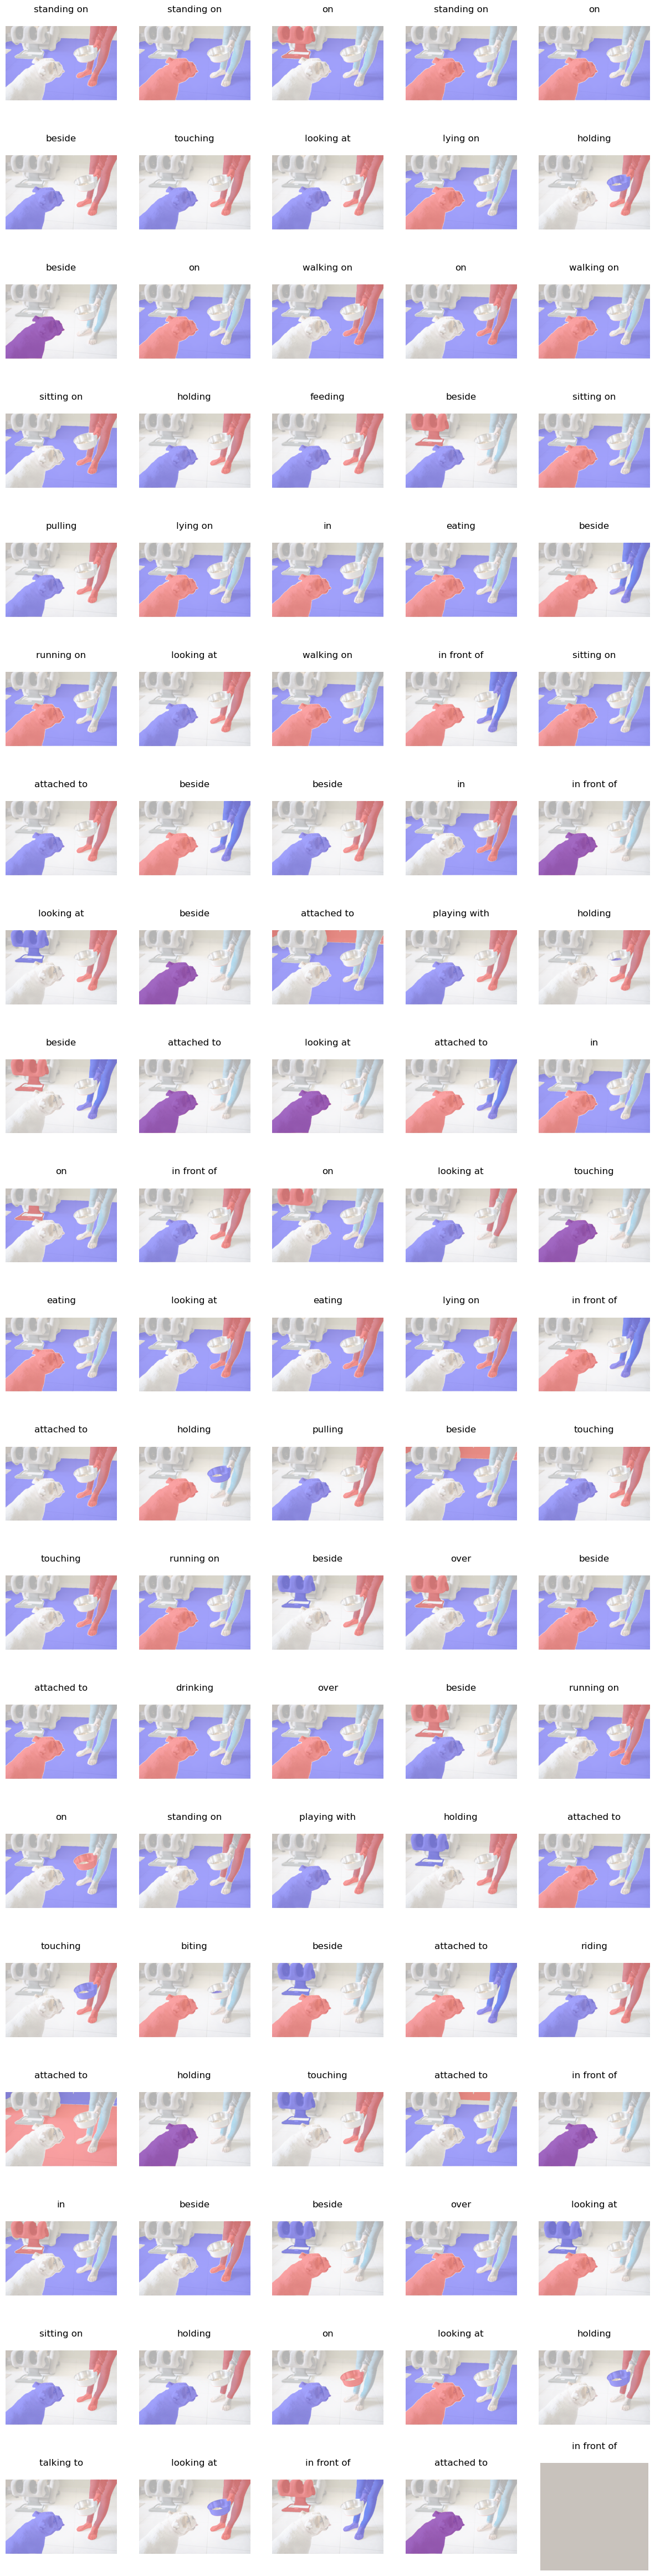

In [34]:
import math

# Calculate the number of rows needed
num_rows = math.ceil(len(rel_triplets) / 5)

# Create the subplots
fig, axs = plt.subplots(num_rows, 5, figsize=(15, 3*num_rows))
# Loop through the images and add them to the subplots
for i, rel in enumerate(rel_triplets):
    s,o,r = int(rel[0]),int(rel[1]),int(rel[2])
    row = i // 5
    col = i % 5
    
    axs[row, col].imshow(image, alpha=0.3)
    if s == 0:
        axs[row, col].imshow(show_mask(mask1[0]))
    else:
        axs[row, col].imshow(show_anns(filtered_masks[s-1:s], 'red'))

    if o == 0:
        axs[row, col].imshow(show_mask(mask1[0], 'blue'))
    else:
        axs[row, col].imshow(show_anns(filtered_masks[o-1:o], 'blue'))

    axs[row, col].axis('off')
    
    # compute relations
    
    # concat_input = torch.cat((feat1, feat2), dim=2)
    # output = matrix_output[:,s,o,r]
    
    # topk_indices = torch.argsort(-output).flatten()
    strings = [relation_classes[r] + '\n']
    result = ''.join(strings)
    
    axs[row, col].set_title(result)
    

# Display the subplots
plt.show()

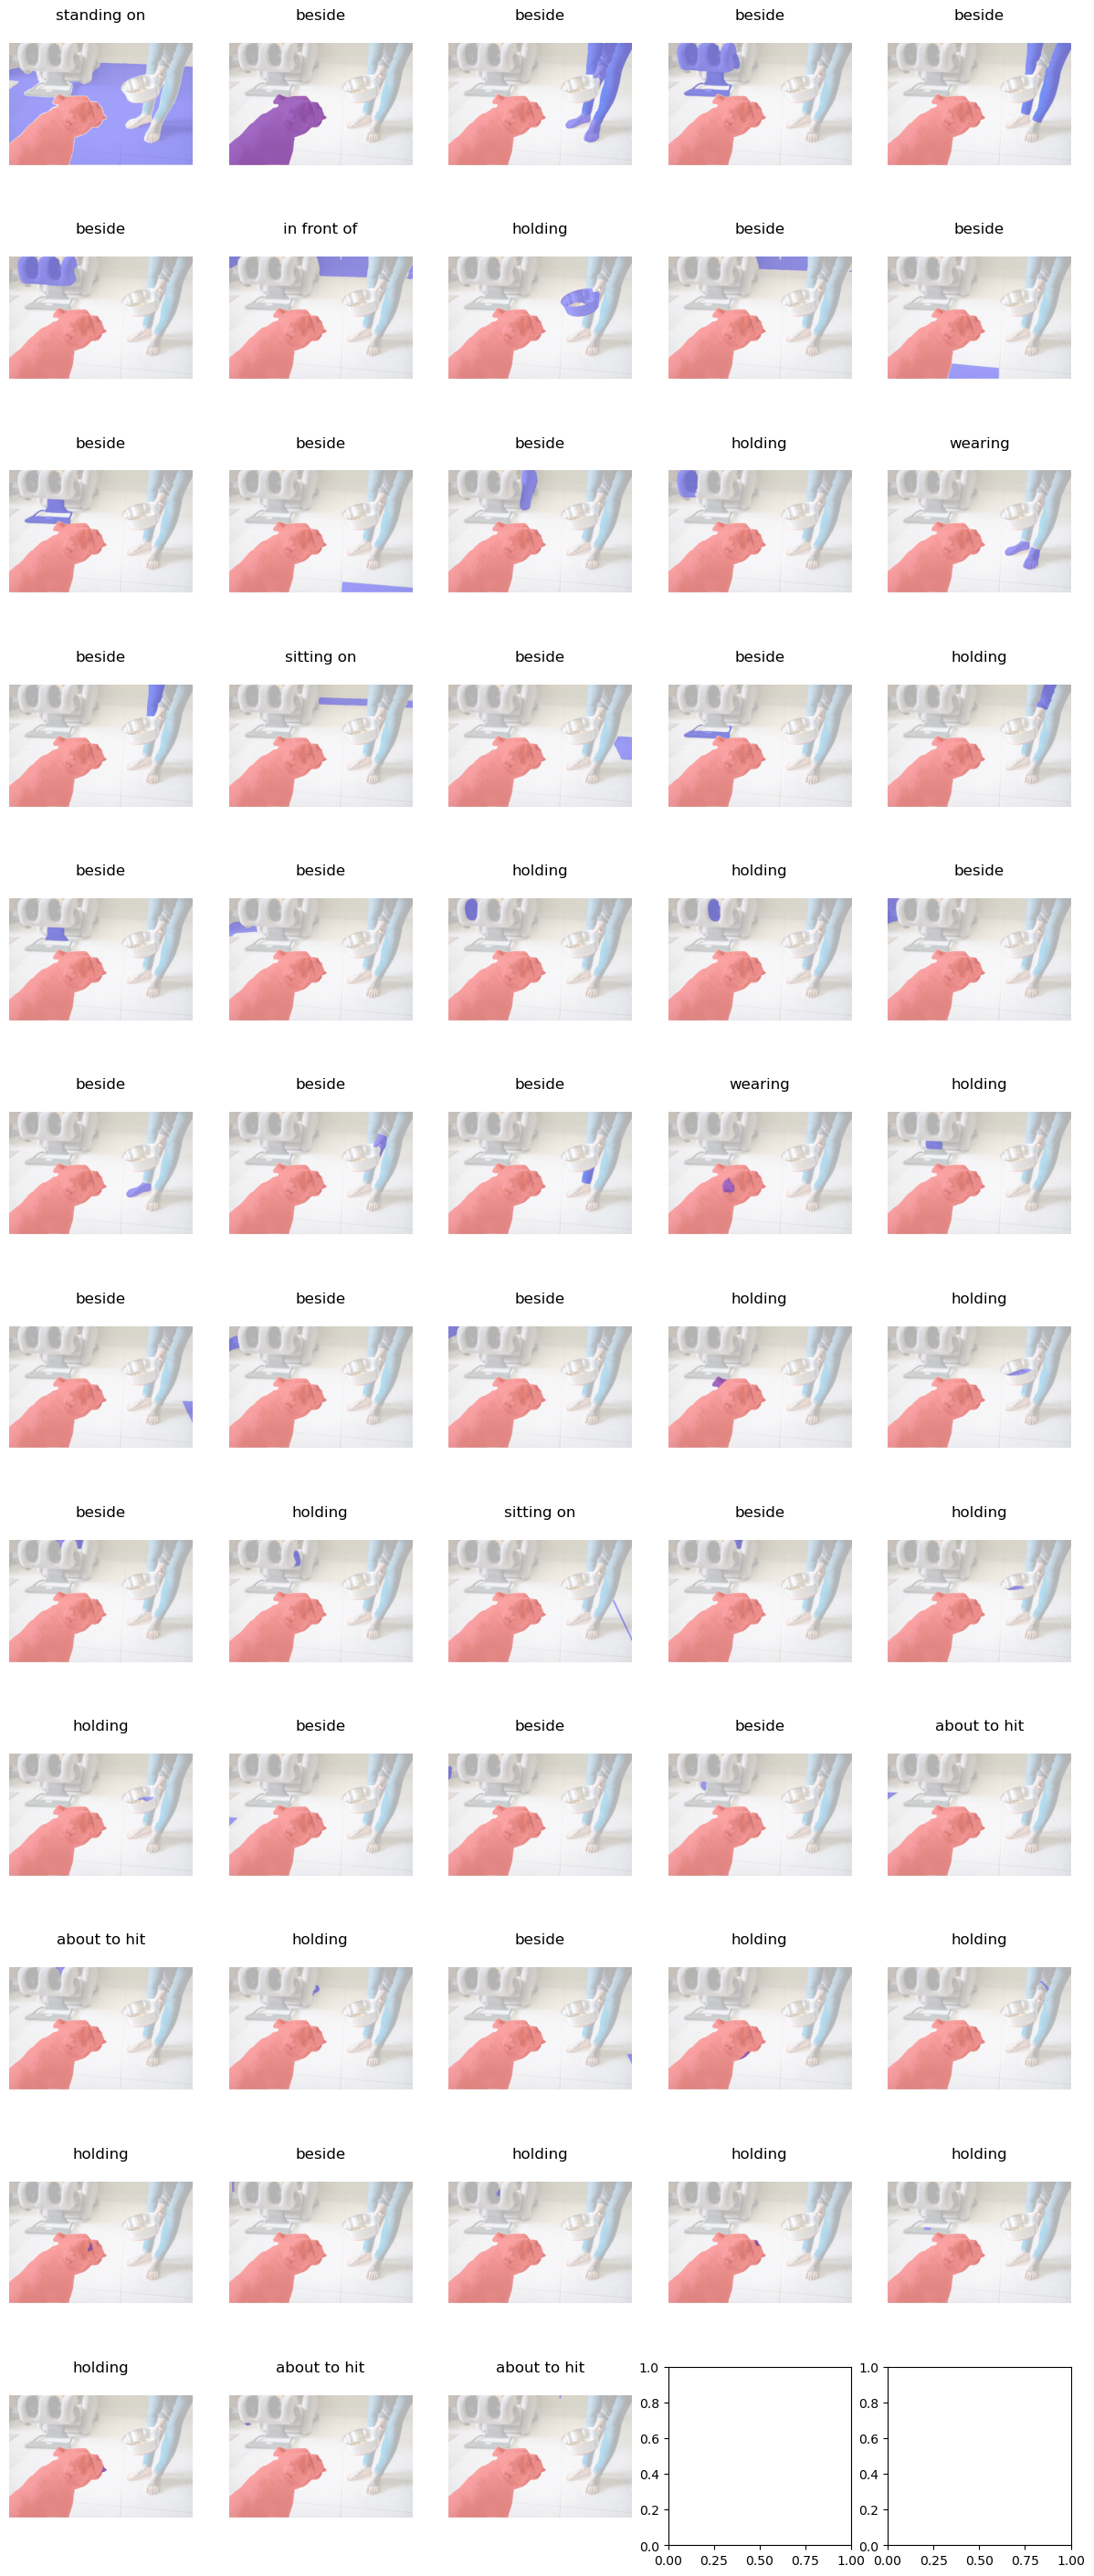

In [154]:
all_output = matrix_output.permute([0,2,3,1])[:,0,1:]

import math

# Calculate the number of rows needed
num_rows = math.ceil(len(filtered_masks) / 5)

# Create the subplots
fig, axs = plt.subplots(num_rows, 5, figsize=(15, 3*num_rows))
# Loop through the images and add them to the subplots
for i, mask in enumerate(filtered_masks):
    row = i // 5
    col = i % 5
    
    axs[row, col].imshow(image, alpha=0.3)
    axs[row, col].imshow(show_mask(mask1[0],'red'))
    axs[row, col].imshow(show_anns(filtered_masks[i:i+1], 'blue'))
    axs[row, col].axis('off')
    
    # compute relations
    
    # concat_input = torch.cat((feat1, feat2), dim=2)
    output = all_output[:,i]
    
    topk_indices = torch.argsort(-output).flatten()
    strings = [relation_classes[indice] + '\n' for indice in topk_indices[:k]]
    result = ''.join(strings)
    
    axs[row, col].set_title(result)
    

# Display the subplots
plt.show()

In [171]:
from PIL import Image, ImageDraw, ImageFont

def create_title_image(word1, word2, word3, width, font_path='OpenSans-Bold.ttf'):
    # Define the colors to use for each word
    color_red = (255, 0, 0)
    color_black = (0, 0, 0)
    color_blue = (0, 0, 255)

    # Define the initial font size and spacing between words
    font_size = 40

    # Create a new image with the specified width and white background
    image = Image.new('RGB', (width, 60), (255, 255, 255))

    # Load the specified font
    font = ImageFont.truetype(font_path, font_size)

    # Keep increasing the font size until all words fit within the desired width
    while True:
        # Create a draw object for the image
        draw = ImageDraw.Draw(image)
        
        word_spacing = font_size / 2
        # Draw each word in the appropriate color
        x_offset = word_spacing
        draw.text((x_offset, 0), word1, color_red, font=font)
        x_offset += font.getsize(word1)[0] + word_spacing
        draw.text((x_offset, 0), word2, color_black, font=font)
        x_offset += font.getsize(word2)[0] + word_spacing
        draw.text((x_offset, 0), word3, color_blue, font=font)
        
        word_sizes = [font.getsize(word) for word in [word1, word2, word3]]
        total_width = sum([size[0] for size in word_sizes]) + word_spacing * 3

        # Stop increasing font size if the image is within the desired width
        if total_width <= width:
            break
            
        # Increase font size and reset the draw object
        font_size -= 1
        image = Image.new('RGB', (width, 50), (255, 255, 255))
        font = ImageFont.truetype(font_path, font_size)
        draw = None

    return image

/tmp/ipykernel_3681751/2841850064.py:27: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  x_offset += font.getsize(word1)[0] + word_spacing
/tmp/ipykernel_3681751/2841850064.py:29: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  x_offset += font.getsize(word2)[0] + word_spacing
/tmp/ipykernel_3681751/2841850064.py:32: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  word_sizes = [font.getsize(word) for word in [word1, word2, word3]]


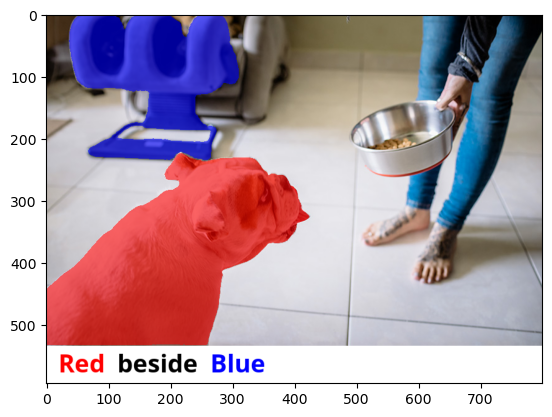

In [173]:
import random
def draw_selected_mask(mask, draw):
    color = (255, 0, 0, 153)
    nonzero_coords = np.transpose(np.nonzero(mask))
    for coord in nonzero_coords:
        draw.point(coord[::-1], fill=color)

def draw_object_mask(mask, draw):
    color = (0, 0, 255, 153)
    nonzero_coords = np.transpose(np.nonzero(mask))
    for coord in nonzero_coords:
        draw.point(coord[::-1], fill=color)

pil_image = pilimage
pil_image = pil_image.convert('RGBA')
pil_image_list = []
relation_list = []

subject_output = matrix_output.permute([0,2,3,1])[:,0,1:]

for i in range(len(filtered_masks)):
    
    output = subject_output[:,i]
    
    topk_indices = torch.argsort(-output).flatten()
    relation = relation_classes[topk_indices[:1][0]]
    
    mask_image = Image.new('RGBA', pil_image.size, color=(0, 0, 0, 0))
    mask_draw = ImageDraw.Draw(mask_image)
        
    draw_selected_mask(mask1[0], mask_draw)
    draw_object_mask(filtered_masks[i]['segmentation'], mask_draw)

    current_pil_image = pil_image.copy()
    current_pil_image.alpha_composite(mask_image)
    
    
    title_image = create_title_image('Red', relation, 'Blue', current_pil_image.size[0])
    concate_pil_image = concatenate_images_vertical(current_pil_image, title_image)
    
    plt.imshow(concate_pil_image)

In [158]:
current_pil_image.size[0]

800

In [148]:
subject_max_value = subject_value_list.flatten()[0]
subject_max_index = subject_index_list.flatten()[0]

object_max_value = object_value_list.flatten()[0]
object_max_index = object_index_list.flatten()[0]

In [152]:
subject_max_index

tensor(14, device='cuda:0')

In [129]:
def concatenate_images_vertical(image1, image2):
    # Get the dimensions of the two images
    width1, height1 = image1.size
    width2, height2 = image2.size

    # Create a new image with the combined height and the maximum width
    new_image = Image.new('RGBA', (max(width1, width2), height1 + height2))

    # Paste the first image at the top of the new image
    new_image.paste(image1, (0, 0))

    # Paste the second image below the first image
    new_image.paste(image2, (0, height1))

    return new_image

In [144]:
object_max_value

tensor([-8.0547e-03, -7.8120e-03, -5.2919e-03, -2.0818e-03, -8.4239e-04,
        -3.9051e-04, -2.3401e-04, -1.1777e-04, -1.0891e-04, -5.4970e-05,
        -4.6406e-05, -2.9324e-05, -2.9039e-05, -2.6076e-05, -2.5945e-05,
        -2.5147e-05, -2.5089e-05, -2.3082e-05, -2.0085e-05, -1.8166e-05,
        -1.7561e-05, -1.6374e-05, -1.3796e-05, -1.1838e-05, -1.0840e-05,
        -9.8080e-06, -9.3477e-06, -8.8945e-06, -8.4092e-06, -8.1482e-06,
        -8.1155e-06, -6.7209e-06, -5.4372e-06, -4.9092e-06, -4.4218e-06,
        -3.6878e-06, -3.0752e-06, -2.8946e-06, -1.7450e-06, -1.5223e-06,
        -1.3602e-06, -1.3077e-06, -1.1800e-06, -9.7051e-07, -8.5568e-07,
        -6.2054e-07, -5.4184e-07, -2.8898e-07, -1.8736e-07, -1.7358e-07,
        -1.2309e-07, -1.0666e-07, -5.7851e-08, -5.2307e-08, -5.0855e-08,
        -3.0825e-08], device='cuda:0', grad_fn=<SelectBackward>)

/tmp/ipykernel_3681751/2073906752.py:25: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  x_offset += font.getsize(word1)[0] + word_spacing
/tmp/ipykernel_3681751/2073906752.py:27: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  x_offset += font.getsize(word2)[0] + word_spacing


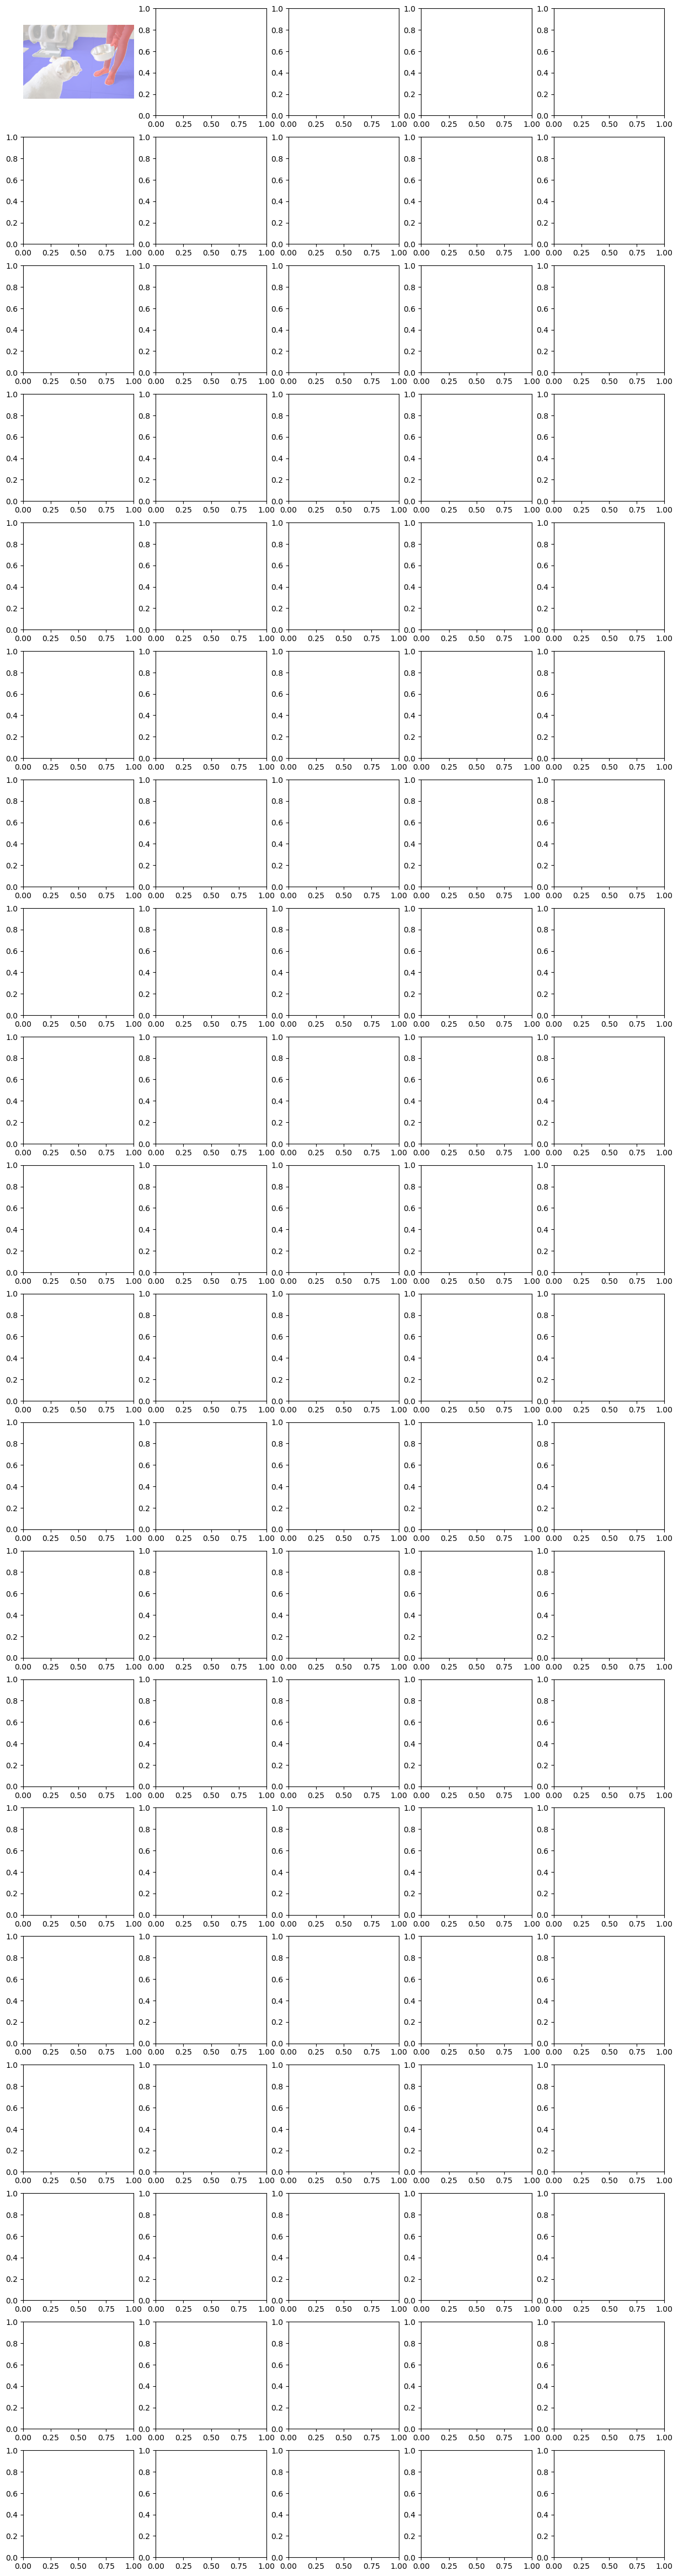

In [61]:
import math

# Calculate the number of rows needed
num_rows = math.ceil(len(rel_triplets) / 5)

# Create the subplots
fig, axs = plt.subplots(num_rows, 5, figsize=(15, 3*num_rows))
# Loop through the images and add them to the subplots
for i, rel in enumerate(rel_triplets[:1]):
    s,o,r = int(rel[0]),int(rel[1]),int(rel[2])
    row = i // 5
    col = i % 5
    
    # Create the title image
    title_image = create_title_image('Red', relation_classes[r], 'Blue')
    
    # Put the title image on top of the subplot image
    axs[row, col].imshow(image, alpha=0.3)
    
    if s == 0:
        axs[row, col].imshow(show_mask(mask1[0]))
    else:
        axs[row, col].imshow(show_anns(filtered_masks[s-1:s], 'red'))

    if o == 0:
        axs[row, col].imshow(show_mask(mask1[0], 'blue'))
    else:
        axs[row, col].imshow(show_anns(filtered_masks[o-1:o], 'blue'))

    axs[row, col].axis('off')
    
    axs[row, col].imshow(title_image, extent=(0, image.shape[1], image.shape[0] + title_image.size[0], image.shape[0]))

    
# Display the subplots
plt.show()
